In [37]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

from pathlib import Path
import json
from utils import load_arguments, get_boxed_answer
from latex_formater import get_final_answer, process_docs, process_results, is_equiv
# from model_generate import load_datasets, prompt_generator, load_model
# from blocks import Batch, Block
import itertools
import pandas as pd

root_dir = Path('~/model_evals_ampere8/').expanduser()

# load the name maps
with open('name_maps.json', 'r') as f:
    name_maps = json.load(f)
    DATASET_MAP = name_maps['DATASET_MAP']
    MODEL_MAP = name_maps['MODEL_MAP']

In [38]:
with open(root_dir / 'Algebra_train/Deepseek-67b/teacher_forcing/output.json', 'r') as f:
    predictions = json.load(f)

predictions[1]

{'tfa': 0.8633093237876892,
 'tfce': 0.4637448489665985,
 'perpelexity': 1.5900172241410808,
 'sumCE': 64.46053314208984,
 'bpc': 0.2861442815296975,
 'total_num_tokens': 847,
 'prompt_num_tokens': 708,
 'solution_num_tokens': 139,
 'total_num_chars': 2273,
 'prompt_num_chars': 1948,
 'solution_num_chars': 325}

In [39]:
def load_predictions(path):
    if not (path / 'output.json').exists():
        return []
    with open(path / 'output.json', 'r') as f:
        return json.load(f)


predictions = pd.DataFrame([
    {
        'dataset': dataset.name,
        'model': model.name,
        'method': method.name,
        'prediction': prediction,
        'i': i,
        'generation_args': load_arguments(method / 'args.json')
    }
    for dataset in root_dir.iterdir()
    for model in dataset.iterdir()
    for method in model.iterdir()
    for i, prediction in enumerate(load_predictions(method))
])
args = predictions.iloc[0]['generation_args']

In [40]:
predictions.head(n=10)

,dataset,model,method,prediction,i,generation_args
0,Number_Theory_train,Mixtral-8x22b-Instruct-v0.1,teacher_forcing,"{'tfa': 0.7894737124443054, 'tfce': 0.74296134...",0,"Namespace(debug=False, seed=None, model='mistr..."
1,Number_Theory_train,Mixtral-8x22b-Instruct-v0.1,teacher_forcing,"{'tfa': 0.7287735939025879, 'tfce': 0.88184529...",1,"Namespace(debug=False, seed=None, model='mistr..."
2,Number_Theory_train,Mixtral-8x22b-Instruct-v0.1,teacher_forcing,"{'tfa': 0.7555555701255798, 'tfce': 0.77704483...",2,"Namespace(debug=False, seed=None, model='mistr..."
3,Number_Theory_train,Mixtral-8x22b-Instruct-v0.1,teacher_forcing,"{'tfa': 0.7969924807548523, 'tfce': 0.64349699...",3,"Namespace(debug=False, seed=None, model='mistr..."
4,Number_Theory_train,Mixtral-8x22b-Instruct-v0.1,teacher_forcing,"{'tfa': 0.6966292262077332, 'tfce': 1.18482685...",4,"Namespace(debug=False, seed=None, model='mistr..."
5,Number_Theory_train,Mixtral-8x22b-Instruct-v0.1,teacher_forcing,"{'tfa': 0.7894737124443054, 'tfce': 0.74296134...",5,"Namespace(debug=False, seed=None, model='mistr..."
6,Number_Theory_train,Mixtral-8x22b-Instruct-v0.1,teacher_forcing,"{'tfa': 0.7287735939025879, 'tfce': 0.88184529...",6,"Namespace(debug=False, seed=None, model='mistr..."
7,Number_Theory_train,Mixtral-8x22b-Instruct-v0.1,teacher_forcing,"{'tfa': 0.7555555701255798, 'tfce': 0.77704483...",7,"Namespace(debug=False, seed=None, model='mistr..."
8,Number_Theory_train,Mixtral-8x22b-Instruct-v0.1,teacher_forcing,"{'tfa': 0.7969924807548523, 'tfce': 0.64349699...",8,"Namespace(debug=False, seed=None, model='mistr..."
9,Number_Theory_train,Mixtral-8x22b-Instruct-v0.1,teacher_forcing,"{'tfa': 0.6966292262077332, 'tfce': 1.18482685...",9,"Namespace(debug=False, seed=None, model='mistr..."


In [3]:
# args.model = 'mistralai/Mistral-7B-Instruct-v0.2'
# args.use_chat = True
# args.model = 'mistralai/Mixtral-8x7B-Instruct-v0.1'
# args.use_chat = True
# args.model = 'tiiuae/falcon-7b'  # Don't use?
# args.use_chat = False
# args.model = 'meta-llama/Llama-2-7b-chat--hf'
# args.use_chat = True
# args.model = 'meta-llama/Llama-2-13b-chat-hf'
# args.use_chat = True
# args.model = 'meta-llama/Llama-2-70b-chat-hf'
# args.use_chat = True
# args.model = 'meta-llama/Meta-Llama-3-8B-Instruct'
# args.use_chat = True
# args.model = 'meta-llama/Meta-Llama-3-70B-Instruct'
# args.use_chat = True
# args.model = 'deepseek-ai/deepseek-math-7b-instruct'
# args.use_chat = True
# args.model = 'deepseek-ai/deepseek-llm-67b-chat'
# args.use_chat = True

In [41]:
%%capture
DATASET_CONFIGS = {
    'EleutherAI/hendrycks_math': {
        'subsets': ['algebra', 'counting_and_probability', 'geometry', 'intermediate_algebra',
                    'number_theory', 'prealgebra', 'precalculus'],
        'aliases': ['hendrycks_math', 'math', 'hendrycks'],
    }
}

DATASET_ALIASES = {alias: dataset_name
                   for dataset_name, config in DATASET_CONFIGS.items()
                   for alias in config['aliases']}
DATASET_ALIASES.update({dataset_name: dataset_name for dataset_name in DATASET_CONFIGS})
import datasets as hf_datasets


def load_datasets(args):
    datasets = {}
    for dataset_name in args.dataset.split(','):
        dataset_name = dataset_name.strip()
        assert dataset_name in DATASET_ALIASES, f'Unknown dataset {dataset_name}'
        dataset_name = DATASET_ALIASES[dataset_name]

        for subset in DATASET_CONFIGS[dataset_name]['subsets']:
            try:
                dataset = hf_datasets.load_dataset(dataset_name, subset)[args.split]
            except ValueError as e:  # @TODO: get right exception type
                print(e)
                print(f'Error while loading {dataset_name}:{subset}. Redownloading...')
                dataset = hf_datasets.load_dataset(dataset_name, subset, download_mode='force_redownload',
                                                   verification_mode='no_checks')[args.split]
            datasets[f'{dataset_name}:{subset}'] = dataset

    return datasets


datasets = load_datasets(args)
datasets = pd.DataFrame([
    {
        'dataset': f'{DATASET_MAP[dataset_name]}_{args.split}',
        'i': i,
        **datapoint
    }
    for dataset_name, dataset in datasets.items()
    for i, datapoint in enumerate(process_docs(dataset))
])


# def groupby(datasets, key):
#     return {k: list(g) for k, g in itertools.groupby(datasets, key=lambda x: x[key])}

In [42]:
# merge predictions and datasets on ['dataset', 'i']
results = datasets.merge(predictions, on=['dataset', 'i'])

save_path = Path('~/GitHub/gold-ai-olympiad/data/MATH/Predictions/TF').expanduser()
save_path.mkdir(exist_ok=True, parents=True)
import json

results_copy = results.copy()
results_copy['generation_args'] = results_copy['generation_args'].apply(lambda x: x.__dict__)

# save each dataset in a different file
for dataset_name, dataset in results_copy.groupby('dataset'):
    with open(save_path / f'{dataset_name}.json', 'w') as f:
        json.dump(dataset.to_dict('records'), f)

In [33]:
# load the results and combine them back into a single dataframe
results = pd.concat([
    pd.read_json(save_path / f)
    for f in save_path.iterdir()
    if f.suffix == '.json'
])

In [34]:
set(predictions['prediction']) == set(results['prediction'])

TypeError: unhashable type: 'dict'

In [18]:
# get the prompts
dataset_name = 'Number_Theory_train'
prompt_gen = prompt_generator(args)
prompts = prompt_gen(Batch(datasets.query('dataset == @dataset_name').to_dict('records')))
prompts[0]

[{'role': 'user',
  'content': 'If 25,197,624 hot dogs are packaged in sets of 4, how many will be left over?\nPlease reason step by step, and put your final answer within \\boxed{}.'},
 {'role': 'assistant',
  'content': 'We look for the remainder when $25,197,624$ is divided by $4$. We could manually divide to see that $4$ divides evenly into $25,197,624$ for a remainder of $0$, but the quicker way is to know the divisibility rule for $4$. If the last two digits of the number form a multiple of $4$, then the number itself is divisible by $4$.  In this case, $24$ is a multiple of $4$, so $25,197,624$ is also a multiple of $4$. That means $\\boxed{0}$ hot dogs will be left over.'},
 {'role': 'user',
  'content': 'How many three-digit perfect cubes are divisible by $9?$\nPlease reason step by step, and put your final answer within \\boxed{}.'},
 {'role': 'assistant',
  'content': 'A cube is divisible by $9$ if the number being cubed is divisible by $\\sqrt[3]{9}=3^{\\frac{2}{3}}.$ Since

In [97]:
ex = datasets.iloc[7005]
dataset_name = ex['dataset']
i = ex['i']
ex['problem']

'Compute\n\\[\\begin{pmatrix} 0 & c & -b \\\\ -c & 0 & a \\\\ b & -a & 0 \\end{pmatrix} \\begin{pmatrix} a^2 & ab & ac \\\\ ab & b^2 & bc \\\\ ac & bc & c^2 \\end{pmatrix}.\\]'

In [25]:
predictions.query('model == "Mistral-7b-Instruct-v0.2"').iloc[10]['generation_args']

Namespace(debug=False, seed=None, model='mistralai/Mistral-7B-Instruct-v0.2', backend='vllm', tensor_parallel_size=1, dataset='math', subset=None, split='train', batch_size=8, use_chat=True, output='/lfs/skampere1/0/kaif/model_evals', override=True, temperature=0.8, top_p=0.95, max_tokens=2048, num_shots=4, method='autoregressive')

In [99]:
len(datasets), len(predictions)

(7500, 75000)

In [8]:
i = 4
print(prompts[i])
print('=' * 80)
print(predictions.loc[(dataset_name, 'Deepseek-7b-RL', 'autoregressive')].predictions[i])

[{'role': 'user', 'content': 'Marcus has two numbers, $a$ and $b$.  When he divides $a$ by 45 he gets a remainder of 37.  When he divides $b$ by 30 he gets a remainder of $9$.  What remainder does he get when he divides $a+b$ by 15?\nPlease reason step by step, and put your final answer within \\boxed{}.'}, {'role': 'assistant', 'content': 'Marcus has two equations: \\[a=45n+37\\]and \\[b=30m+9.\\]When he adds these he gets \\[a+b=45n+30m+37+9=15(3n+2m)+46=15(3n+2m+3)+1.\\]The remainder when $a+b$ is divided by 15 is $\\boxed{1}$.'}, {'role': 'user', 'content': 'If $AAA_4$ can be expressed as $33_b$, where $A$ is a digit in base 4 and $b$ is a base greater than 5, what is the smallest possible sum $A+b$?\nPlease reason step by step, and put your final answer within \\boxed{}.'}, {'role': 'assistant', 'content': 'We can rewrite $AAA_4$ and $33_b$ to get \\begin{align*}\n16A+4A+A&=3b+3\\quad\\Rightarrow\\\\\n21A&=3b+3.\n\\end{align*}The smallest possible value for $A$ is 1, which gives u

In [8]:
class Metric():
    def __init__(self, datasets):
        super().__init__()
        self.datasets = datasets

    def process(self, predictions):
        pass

    def __call__(self, predictions):
        return self.process(predictions)

In [14]:
# def get_answer(solution: str):
#     return latex_deformat(get_boxed_answer(str(solution)))


class BoxedMatch(Metric):
    def process(self, predictions):
        predictions['boxed'] = predictions['prediction'].apply(get_final_answer)
        results = self.datasets.merge(predictions, on=['dataset', 'i'], suffixes=('_true', '_pred'))
        results['match'] = results['boxed_true'] == results['boxed_pred']

        # very slow, probably don't use
        # results['match'] = results.apply(lambda x: is_equiv(x['boxed_true'], x['boxed_pred']), axis=1)

        # set first columns to be ['dataset', 'i', 'model', 'method', 'boxed_true', 'boxed_pred', 'match', ...]
        cols = ['dataset', 'i', 'model', 'method', 'boxed_true', 'boxed_pred', 'match']
        cols.extend([col for col in results.columns if col not in cols])
        return results[cols]

In [18]:
def apply_metric(predictions, metric, datasets):
    m = metric(datasets)
    results = m(predictions)
    return results

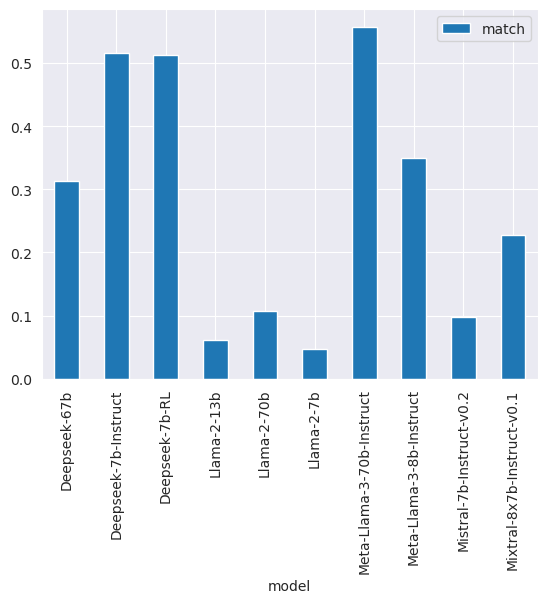

In [17]:
boxed_match = apply_metric(predictions, BoxedMatch, datasets)
boxed_accuracy = boxed_match.groupby(['model', 'method'])['match'].mean().reset_index().plot(kind='bar', x='model',
                                                                                             y='match')

<Axes: xlabel='model'>

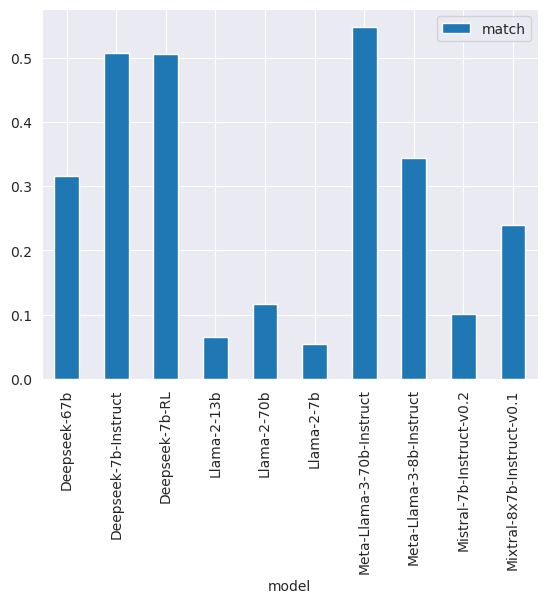

In [13]:
boxed_match.groupby(['model', 'method'])['match'].mean().reset_index().plot(kind='bar', x='model', y='match')

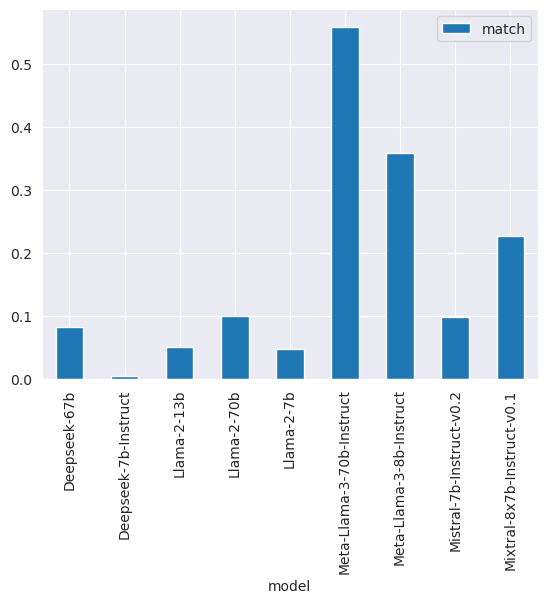

In [22]:
boxed_match = apply_metric(predictions, BoxedMatch, datasets)
boxed_accuracy = boxed_match.groupby(['model', 'method'])['match'].mean().reset_index().plot(kind='bar', x='model',
                                                                                             y='match')

In [176]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot each dataset on a separate subplot
g = sns.relplot(
    data=boxed_accuracy,
    x='model',
    y='match',
    hue='model',
    col='dataset',
    # kind='bar',
    col_wrap=3,
)

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1500x0 with 0 Axes>

In [20]:
i = 5
print('Question:')
print(prompts[i])
print('Answer:')
print(outputs[i])

Question:
[{'role': 'user', 'content': 'Let $A$ be the set of all numbers which can be represented as the sum of three consecutive positive integers. What is the greatest common divisor of all numbers in $A$?\nPlease reason step by step, and put your final answer within \\boxed{}.'}, {'role': 'assistant', 'content': 'Each member in the set is of the form $(x-1)+x+(x+1)=3x$. Since $x$ can be any positive integer, the greatest common divisor of all these members is $\\boxed{3}$.'}, {'role': 'user', 'content': 'How many integers between 100 and 300 have both 11 and 8 as factors?\nPlease reason step by step, and put your final answer within \\boxed{}.'}, {'role': 'assistant', 'content': 'The only numbers that have 11 and 8 as a factor are multiples of 88.  If we list the first few multiples of 88: $$88,176,264,352,...$$ we can see that there are exactly $\\boxed{2}$ between 100 and 300.'}, {'role': 'user', 'content': 'Express .$\\overline{28}$ as a common fraction.\nPlease reason step by s